In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
%cd /content/drive/My\ Drive/dcec
%ls

/content/drive/My Drive/dcec
model.h5  models/  weights/


In [0]:
import numpy as np
import keras
import matplotlib.pyplot as plt
from pathlib import Path
from keras.datasets import mnist
from keras import Model
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import classification_report
from models.dcec import DCEC
from sklearn.manifold import TSNE
import tensorflow as tf
import scipy
import seaborn as sns

from sklearn.metrics.cluster import contingency_matrix

from keras.layers import Conv2D, Conv2DTranspose, Dense, Flatten, Reshape
from keras.models import Sequential, Model

In [0]:
!nvidia-smi

Thu May 21 21:36:30 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### Replication of Results

### HyperParameters Found in the Paper
- Batch size 256
- Epochs 200

```

In [0]:
img_rows, img_cols = 28, 28
batch_size = 256
(mnist_train_data, mnist_train_labels), (mnist_test_data, mnist_test_labels) = mnist.load_data()
mnist_train_data = mnist_train_data.reshape(mnist_train_data.shape[0], img_rows, img_cols, 1)
mnist_train_data = mnist_train_data.astype('float32')
mnist_train_data /= 255
mnist_test_data = mnist_test_data.reshape(mnist_test_data.shape[0], img_rows, img_cols, 1)
mnist_test_data = mnist_test_data.astype('float32')
mnist_test_data /= 255
print(f'MNIST train shape:  {mnist_train_data.shape}')
print(f'MNIST validation shape: {mnist_test_data.shape}')

11493376/11490434 [==============================] - 0s 0us/step
MNIST train shape:  (60000, 28, 28, 1)
MNIST validation shape: (10000, 28, 28, 1)


In [0]:
def CAE(input_shape=(28, 28, 1), filters=[32, 64, 128, 10], use_norm=False):
    model = keras.models.Sequential()
    if input_shape[0] % 8 == 0:
        pad3 = 'same'
    else:
        pad3 = 'valid'
    model.add(Conv2D(filters[0], 5, strides=2, padding='same', activation='relu', name='conv1', input_shape=input_shape))
    model.add(Conv2D(filters[1], 5, strides=2, padding='same', activation='relu', name='conv2'))
    model.add(Conv2D(filters[2], 3, strides=2, padding=pad3, activation='relu', name='conv3'))
    model.add(Flatten())
    
    if use_norm:
      model.add(Dense(units=filters[3], name='dense1'))
      model.add(keras.layers.Lambda(lambda x: tf.keras.backend.l2_normalize(x, axis=0), name='embedding'))
    else:
      model.add(Dense(units=filters[3], name='embedding'))

    model.add(Dense(units=filters[2]*int(input_shape[0]/8)*int(input_shape[0]/8), activation='relu'))
    model.add(Reshape((int(input_shape[0]/8), int(input_shape[0]/8), filters[2])))
    model.add(Conv2DTranspose(filters[1], 3, strides=2, padding=pad3, activation='relu', name='deconv3'))
    model.add(Conv2DTranspose(filters[0], 5, strides=2, padding='same', activation='relu', name='deconv2'))
    model.add(Conv2DTranspose(input_shape[2], 5, strides=2, padding='same', name='deconv1'))
    model.summary()
    return model



In [0]:
cae = CAE()
cae_l2 = CAE(use_norm=True)

cae.compile(optimizer='adam', loss='mse')
cae_l2.compile(optimizer='adam', loss='mse')


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 14, 14, 32)        832       
_________________________________________________________________
conv2 (Conv2D)               (None, 7, 7, 64)          51264     
_________________________________________________________________
conv3 (Conv2D)               (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
embedding (Dense)            (None, 10)                11530     
_________________________________________________________________
dense_1 (Dense)              (None, 1152)              12672     
_________________________________________________________________
reshape_1 (Reshape)          (None, 3, 3, 128)        

# Model without $L_2$ Norm 

In [0]:
epochs = 100

if True:
  checkpoint = ModelCheckpoint("weights/dcec_best_model.hdf5", monitor='loss', verbose=1,
      save_best_only=True, mode='auto', period=50)

  cae.fit(mnist_train_data, 
          mnist_train_data, 
          batch_size=batch_size, 
          epochs=epochs,
          verbose=1)
          # callbacks=[checkpoint])

  cae.save_weights(f"weights/cae_final_model_{epochs}_{batch_size}.h5")
else:
  cae.load_weights(f"weights/cae_final_model_{epochs}_{batch_size}.h5")

Epoch 1/100
60000/60000 [==============================] - 10s 160us/step - loss: 0.0330
Epoch 2/100
60000/60000 [==============================] - 3s 53us/step - loss: 0.0169
Epoch 3/100
60000/60000 [==============================] - 3s 53us/step - loss: 0.0151
Epoch 4/100
60000/60000 [==============================] - 3s 53us/step - loss: 0.0142
Epoch 5/100
60000/60000 [==============================] - 3s 53us/step - loss: 0.0135
Epoch 6/100
60000/60000 [==============================] - 3s 53us/step - loss: 0.0130
Epoch 7/100
60000/60000 [==============================] - 3s 52us/step - loss: 0.0126
Epoch 8/100
60000/60000 [==============================] - 3s 52us/step - loss: 0.0122
Epoch 9/100
60000/60000 [==============================] - 3s 53us/step - loss: 0.0119
Epoch 10/100
60000/60000 [==============================] - 3s 53us/step - loss: 0.0117
Epoch 11/100
60000/60000 [==============================] - 3s 52us/step - loss: 0.0115
Epoch 12/100
60000/60000 [=============

# Model with $L_2$ Norm

In [0]:
epochs = 100

if True:
  checkpoint = ModelCheckpoint("weights/dcec_best_model.hdf5", monitor='loss', verbose=1,
      save_best_only=True, mode='auto', period=50)

  cae_l2.fit(mnist_train_data, 
          mnist_train_data, 
          batch_size=batch_size, 
          epochs=epochs,
          verbose=1)
          # callbacks=[checkpoint])

  cae_l2.save_weights(f"weights/cae_l2_final_model_{epochs}_{batch_size}.h5")
else:
  cae_l2.load_weights(f"weights/cae_l2_final_model_{epochs}_{batch_size}.h5")

Epoch 1/100
60000/60000 [==============================] - 3s 58us/step - loss: 0.0366
Epoch 2/100
60000/60000 [==============================] - 3s 54us/step - loss: 0.0198
Epoch 3/100
60000/60000 [==============================] - 3s 54us/step - loss: 0.0171
Epoch 4/100
60000/60000 [==============================] - 3s 55us/step - loss: 0.0158
Epoch 5/100
60000/60000 [==============================] - 3s 53us/step - loss: 0.0151
Epoch 6/100
60000/60000 [==============================] - 3s 53us/step - loss: 0.0144
Epoch 7/100
60000/60000 [==============================] - 3s 53us/step - loss: 0.0140
Epoch 8/100
60000/60000 [==============================] - 3s 53us/step - loss: 0.0136
Epoch 9/100
60000/60000 [==============================] - 3s 54us/step - loss: 0.0133
Epoch 10/100
60000/60000 [==============================] - 3s 54us/step - loss: 0.0131
Epoch 11/100
60000/60000 [==============================] - 3s 54us/step - loss: 0.0128
Epoch 12/100
60000/60000 [===============

In [0]:
%ls -l weights

total 12160
-rw------- 1 root root 1134408 May 17 15:53 cae_final_model_100_128.h5
-rw------- 1 root root 1134464 May 17 15:38 cae_final_model_100_256.h5
-rw------- 1 root root 1134408 May 16 12:06 cae_final_model_200_256.h5
-rw------- 1 root root 1135288 May 17 15:59 cae_l2_final_model_100_128.h5
-rw------- 1 root root 1135296 May 17 15:46 cae_l2_final_model_100_256.h5
-rw------- 1 root root 1135288 May 16 12:14 cae_l2_final_model_200_256.h5
-rw------- 1 root root 3370136 May 16 10:55 dcec_best_model.hdf5
-rw------- 1 root root 1134464 May 16 10:55 dcec_final_model_200.h5
-rw------- 1 root root 1135288 May 15 17:05 dcec_final_model.h5


In [0]:
def cluster_emb(emb, n_clusters=10):
  clf = KMeans(n_clusters=n_clusters)
  cluster_dist = clf.fit_transform(emb)
  labels = clf.predict(emb)
  return labels, cluster_dist, clf


def m(y_true, y_pred):
  """Find a mapping from ground truth to kmeans labels"""
  cm = contingency_matrix(y_pred, y_true)
  # print(cm)
  # print(np.argmax(cm, axis=1))
  _, assignment = scipy.optimize.linear_sum_assignment(-cm)
  print(assignment)
  return np.asarray([assignment[l] for l in y_pred])


def plot_tnse(data, titles, y_true, layout, selection_size=1000):
  tsne_selection = np.random.permutation(len(embeddings))[:selection_size]
  for i, ((_d, _y_pred), _t), in enumerate(zip(data, titles)):
    tsne_emb = TSNE(n_components=2).fit_transform(_d[tsne_selection])
    labels_m = m(y_true, _y_pred)
    plt.subplot(*layout, i+1)
    g = sns.scatterplot(tsne_emb[:, 0], tsne_emb[:, 1], hue=labels[tsne_selection], legend="full", palette="Paired").set_title(f"TNSE of {_t} (N={selection_size})")
    

def report(y_true, labels_unmapped):
  mapping = m(y_true, labels_unmapped)
  print(classification_report(y_true, mapping))
  print("Accuracy: ", (y_true == mapping).mean())


def get_emb(_model, data):
  encoder = keras.Model(inputs=_model.input, outputs=_model.get_layer(name='embedding').output)
  return encoder.predict(data)

In [0]:
# Get emb with l2
encoder = keras.Model(inputs=cae_l2.input, outputs=cae_l2.get_layer(name='embedding').output)
embeddings = encoder.predict(mnist_test_data) 

# Get emb without l2
encoder_no_l2 = keras.Model(inputs=cae.input, outputs=cae.get_layer(name='embedding').output)
embeddings_no_l2 = encoder_no_l2.predict(mnist_test_data)


# Labels
labels, clusters, _ = cluster_emb(embeddings)
labels_no_l2, cluster_no_l2, _ = cluster_emb(embeddings_no_l2)

In [0]:
print("REPORT WITH L2")
report(mnist_test_labels, labels)

REPORT WITH L2
[[  1   0  15  14   7   3   0 935   9 286]
 [ 20   1  13   0  12   9 857   0   1   1]
 [  2   1  21  22   1  11   1   0 894  12]
 [  0   5 941  14   3   0   0  26   1   2]
 [  0 668   3   2  11   2   6   8   1   9]
 [  2   0   3   3 914   1   2  46  11 654]
 [948   0  18   2   0  17  28   1  12  18]
 [  5   0   9 944   0 213   0   0  37  13]
 [  1 459   8   0  34   7   5  12   4  12]
 [  1   1   1   9   0 629  59   0   4   2]]
[7 6 8 2 1 4 0 3 9 5]
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       980
           1       0.94      0.59      0.72      1135
           2       0.95      0.91      0.93      1032
           3       0.77      0.93      0.85      1010
           4       0.56      0.93      0.70       982
           5       0.89      0.71      0.79       892
           6       0.94      0.89      0.92       958
           7       0.74      0.91      0.81      1028
           8       0.93      0.92      0.92  

In [0]:
print("REPORT WITHOUT L2")
report(mnist_test_labels, labels_no_l2)

REPORT WITHOUT L2
[[ 960    0   18    0    0    6   21    1    2   10]
 [   1 1128    6    1    5    5   23   39    5   14]
 [   1    0    3    3  564    1    2   19   10  441]
 [   8    1   40   33    0   13    5    2  922   14]
 [   0    1    7  960    0  105    0    0    7    8]
 [   7    0    9    0    6   14  868    0    6    0]
 [   1    0   12    7    0    1    0  917    5   10]
 [   2    0    0    2    0  737   38    0    3    0]
 [   0    4  935    3    0    0    0   12    0    0]
 [   0    1    2    1  407   10    1   38   14  512]]
[0 1 4 8 3 6 7 5 2 9]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       980
           1       0.92      0.99      0.96      1135
           2       0.98      0.91      0.94      1032
           3       0.88      0.95      0.92      1010
           4       0.54      0.57      0.56       982
           5       0.94      0.83      0.88       892
           6       0.95      0.91      0.93       

[[  1   0  15  14   7   3   0 935   9 286]
 [ 20   1  13   0  12   9 857   0   1   1]
 [  2   1  21  22   1  11   1   0 894  12]
 [  0   5 941  14   3   0   0  26   1   2]
 [  0 668   3   2  11   2   6   8   1   9]
 [  2   0   3   3 914   1   2  46  11 654]
 [948   0  18   2   0  17  28   1  12  18]
 [  5   0   9 944   0 213   0   0  37  13]
 [  1 459   8   0  34   7   5  12   4  12]
 [  1   1   1   9   0 629  59   0   4   2]]
[7 6 8 2 1 4 0 3 9 5]
[[ 960    0   18    0    0    6   21    1    2   10]
 [   1 1128    6    1    5    5   23   39    5   14]
 [   1    0    3    3  564    1    2   19   10  441]
 [   8    1   40   33    0   13    5    2  922   14]
 [   0    1    7  960    0  105    0    0    7    8]
 [   7    0    9    0    6   14  868    0    6    0]
 [   1    0   12    7    0    1    0  917    5   10]
 [   2    0    0    2    0  737   38    0    3    0]
 [   0    4  935    3    0    0    0   12    0    0]
 [   0    1    2    1  407   10    1   38   14  512]]
[0 1 4 8 3 6 7 5

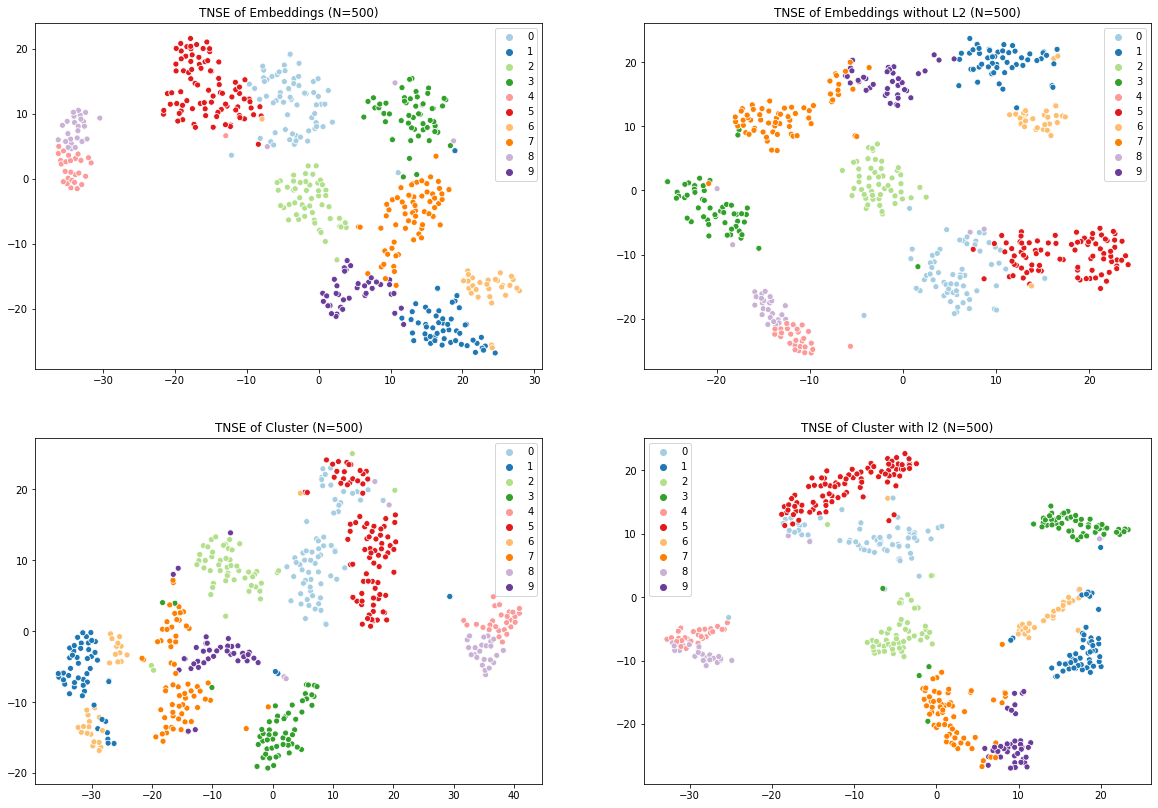

In [0]:
data = [(embeddings, labels), (embeddings_no_l2, labels_no_l2), (clusters, labels), (cluster_no_l2, labels_no_l2)]
titles = ['Embeddings', 'Embeddings without L2' , 'Cluster', 'Cluster with l2']

plt.figure(figsize=(20,14))
plot_tnse(data, titles, mnist_test_labels, (2,2), 500)
plt.show()

NameError: ignored

# Anomaly Detection



Take a random digit and drop 10% in the train set

In [0]:
anomaly_digit = np.random.randint(10)
print(f"Using {anomaly_digit} as anomaly dropping 90% of the training samples")

anomalies = mnist_train_labels == anomaly_digit
selection = np.ones(len(mnist_train_labels), dtype=np.bool)
selection[anomalies] = 0
_selection_anomalies = np.random.choice(len(mnist_train_labels), int(anomalies.sum() * 0.10), replace=False, p=anomalies / anomalies.sum())
selection[_selection_anomalies] = 1

Using 9 as anomaly dropping 90% of the training samples


In [0]:
anomaly_train_data = mnist_train_data[selection]
anomaly_train_labels = mnist_train_labels[selection]

In [0]:
cea_l2_anomaly = CAE(use_norm=True)
cea_l2_anomaly.compile(optimizer='adam', loss='mse')

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 14, 14, 32)        832       
_________________________________________________________________
conv2 (Conv2D)               (None, 7, 7, 64)          51264     
_________________________________________________________________
conv3 (Conv2D)               (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_8 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense1 (Dense)               (None, 10)                11530     
_________________________________________________________________
embedding (Lambda)           (None, 10)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1152)             

In [0]:
cea_l2_anomaly.fit(anomaly_train_data, anomaly_train_data,   
          batch_size=batch_size, 
          epochs=100,
          verbose=1)

Epoch 1/100
54645/54645 [==============================] - 8s 151us/step - loss: 0.0516
Epoch 2/100
54645/54645 [==============================] - 2s 36us/step - loss: 0.0272
Epoch 3/100
54645/54645 [==============================] - 2s 36us/step - loss: 0.0230
Epoch 4/100
54645/54645 [==============================] - 2s 36us/step - loss: 0.0205
Epoch 5/100
54645/54645 [==============================] - 2s 36us/step - loss: 0.0189
Epoch 6/100
54645/54645 [==============================] - 2s 36us/step - loss: 0.0179
Epoch 7/100
54645/54645 [==============================] - 2s 36us/step - loss: 0.0171
Epoch 8/100
54645/54645 [==============================] - 2s 36us/step - loss: 0.0165
Epoch 9/100
54645/54645 [==============================] - 2s 36us/step - loss: 0.0159
Epoch 10/100
54645/54645 [==============================] - 2s 36us/step - loss: 0.0155
Epoch 11/100
54645/54645 [==============================] - 2s 36us/step - loss: 0.0151
Epoch 12/100
54645/54645 [==============

In [0]:
emb = get_emb(cea_l2_anomaly, mnist_train_data)
labels_a, clusters_a, clf_a = cluster_emb(emb, n_clusters=9)


In [0]:
def compute_normality(C, emb):
  norm = emb @ (C.T / np.linalg.norm(C, ord=2, axis=1))
  return norm.max(axis=1)

normality = compute_normality(clf_a.cluster_centers_, get_emb(cea_l2_anomaly, mnist_test_data))

(array([2.370e+02, 1.166e+03, 2.362e+03, 2.598e+03, 2.108e+03, 1.004e+03,
        4.210e+02, 9.700e+01, 5.000e+00, 2.000e+00]),
 array([0.08631857, 0.17670551, 0.26709244, 0.35747936, 0.4478663 ,
        0.53825325, 0.6286402 , 0.7190271 , 0.809414  , 0.89980096,
        0.9901879 ], dtype=float32),
 <a list of 10 Patch objects>)

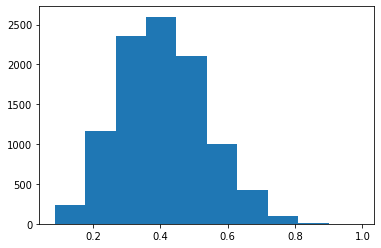

In [0]:
plt.hist(normality)

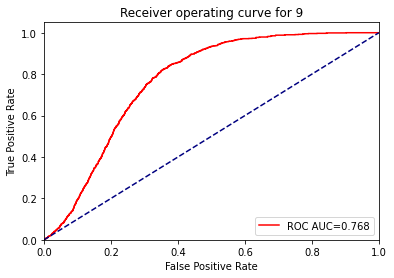

In [0]:

fpr, tpr, thresholds = metrics.roc_curve(mnist_test_labels == anomaly_digit, 1-normality, pos_label=1)
auc_digit = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"ROC AUC={auc_digit:0.3f}", c="r")
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver operating curve for {anomaly_digit}')
plt.legend(loc="lower right")
plt.show()